In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [2]:
pneumonia_frame = pd.read_csv("data_metadata.csv")
n = 4000
img_name = pneumonia_frame.iloc[n, 1]
pneumonia = pneumonia_frame.iloc[n, 5:6]


print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(pneumonia.shape))
print('First 4 Landmarks: {}'.format(pneumonia))

Image name: person498_bacteria_2101.jpeg
Landmarks shape: (1,)
First 4 Landmarks: Label_1_Virus_category    bacteria
Name: 4000, dtype: object


In [3]:
pneumonia_frame.head(2)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
img_name

'person498_bacteria_2101.jpeg'

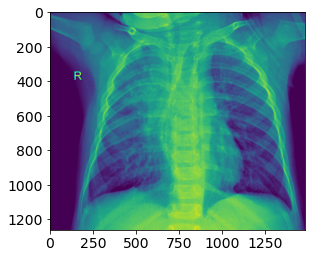

In [5]:
def show_pneumonia(image, pneumonia):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001) 
    
    
plt.figure()
show_pneumonia(io.imread(os.path.join('data/train/1', img_name),as_gray=True),
               pneumonia)
plt.show()# pause a bit so that plots are updated

In [6]:
class PneumoniaDataset(Dataset):
    """Pneumonia dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pneumonia_frame = pd.read_csv(csv_file)
        self.pneumonia_frame = pd.get_dummies(self.pneumonia_frame, columns=['Label'])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pneumonia_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.pneumonia_frame.iloc[idx, 1])
        image = io.imread(img_name, as_gray=False, pilmode="RGB")
        pneumonia = self.pneumonia_frame.iloc[idx, 5:6]
        pneumonia = np.array(float(pneumonia))
        sample = {'image': image, 'pneumonia': pneumonia}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
pneumonia_df = PneumoniaDataset(csv_file='data_metadata.csv',
                                    root_dir='data/train/1')

In [8]:
pneumonia_df[5]['image'].shape

(1152, 1422, 3)

3139 (1064, 1336, 3) 0.0


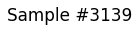

3140 (207, 529, 3) 0.0


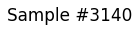

3141 (190, 438, 3) 0.0


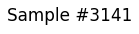

In [9]:
fig = plt.figure()

for i in range(3139,3142):
    sample = pneumonia_df[i]
    print(i, sample['image'].shape, sample['pneumonia'])
    ax = plt.subplot(1, 5000, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_pneumonia(**sample)

In [10]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, pneumonia = sample['image'], sample['pneumonia']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        pneumonia = pneumonia

        return {'image': img, 'pneumonia': pneumonia}

In [11]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, pneumonia = sample['image'], sample['pneumonia']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'pneumonia': pneumonia}

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, pneumonia = sample['image'], sample['pneumonia']
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'pneumonia': torch.from_numpy(pneumonia)}

In [13]:
transformed_dataset = PneumoniaDataset(csv_file='data_metadata.csv',
                                    root_dir='data/train/1',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [14]:
first_data = transformed_dataset[0]

features = first_data["image"]
labels = first_data["pneumonia"]
features,labels


(tensor([[[0.1465, 0.1532, 0.1394,  ..., 0.1948, 0.1647, 0.1592],
          [0.1475, 0.1513, 0.1569,  ..., 0.2514, 0.2246, 0.1913],
          [0.1529, 0.1490, 0.1569,  ..., 0.2792, 0.2657, 0.2362],
          ...,
          [0.3961, 0.4023, 0.4039,  ..., 0.6649, 0.6722, 0.6681],
          [0.3738, 0.3913, 0.3891,  ..., 0.6662, 0.6737, 0.6616],
          [0.3698, 0.3837, 0.3907,  ..., 0.6514, 0.6493, 0.6512]],
 
         [[0.1465, 0.1532, 0.1394,  ..., 0.1948, 0.1647, 0.1592],
          [0.1475, 0.1513, 0.1569,  ..., 0.2514, 0.2246, 0.1913],
          [0.1529, 0.1490, 0.1569,  ..., 0.2792, 0.2657, 0.2362],
          ...,
          [0.3961, 0.4023, 0.4039,  ..., 0.6649, 0.6722, 0.6681],
          [0.3738, 0.3913, 0.3891,  ..., 0.6662, 0.6737, 0.6616],
          [0.3698, 0.3837, 0.3907,  ..., 0.6514, 0.6493, 0.6512]],
 
         [[0.1465, 0.1532, 0.1394,  ..., 0.1948, 0.1647, 0.1592],
          [0.1475, 0.1513, 0.1569,  ..., 0.2514, 0.2246, 0.1913],
          [0.1529, 0.1490, 0.1569,  ...,

In [15]:
labels.shape

torch.Size([])

In [16]:
first_data['image'].shape

torch.Size([3, 224, 224])

In [17]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['pneumonia'].size())

    if i == 10:
        break

0 torch.Size([3, 224, 224]) torch.Size([])
1 torch.Size([3, 224, 224]) torch.Size([])
2 torch.Size([3, 224, 224]) torch.Size([])
3 torch.Size([3, 224, 224]) torch.Size([])
4 torch.Size([3, 224, 224]) torch.Size([])
5 torch.Size([3, 224, 224]) torch.Size([])
6 torch.Size([3, 224, 224]) torch.Size([])
7 torch.Size([3, 224, 224]) torch.Size([])
8 torch.Size([3, 224, 224]) torch.Size([])
9 torch.Size([3, 224, 224]) torch.Size([])
10 torch.Size([3, 224, 224]) torch.Size([])


In [18]:
transformed_dataset.pneumonia_frame.head(2)

,Unnamed: 0,X_ray_image_name,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Label_Normal,Label_Pnemonia
0,0,IM-0128-0001.jpeg,TRAIN,NaN,NaN,1,0
1,1,IM-0127-0001.jpeg,TRAIN,NaN,NaN,1,0


In [19]:
transformed_dataset.root_dir

'data/train/1'

In [20]:
# transformed_dataset.

In [21]:
batch_size = 10
dataloader = DataLoader(transformed_dataset, batch_size = batch_size, shuffle = True)

In [22]:
dataiter= iter(dataloader)
data = dataiter.next()
features = data["image"]
labels = data["pneumonia"]
print(features.shape,labels.shape, len(features), len(labels))

torch.Size([10, 3, 224, 224]) torch.Size([10]) 10 10


In [23]:
data["pneumonia"].shape

torch.Size([10])

In [24]:
data["pneumonia"].shape

torch.Size([10])

In [25]:
# Create a model class with two Convolutional layers with
# same padding (padding = 2, kernel size = 5, stride = 1).
# Implement two max pooling layers where kernel size = 2.
# Close off the model class with one fully connected layer.

#Instantiate the model class.
#Instantiate the loss class.
#Instantiate the optimizer class.

In [26]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
#Instantiate the model class.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size= 5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 1, padding = 0)
        self.fc1 = nn.Linear(in_features = 16 * 222 * 222, out_features = 2) # outfeatues = Number of classes

    def forward(self, x):
        #print(x.shape)
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 222 * 222)
#         x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc1(x)
        return x

In [35]:
net = Net()


In [36]:
#Instantiate the loss class.
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [41]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
net = net.to(device)

#Instantiate the optimizer class.
for epoch in range(5):  # loop over the dataset multiple times
    print("epoch " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs = data["image"].to(device).float()
        labels = data["pneumonia"].to(device).long()
        #print(inputs.shape)
        #print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.shape)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Finished Training


In [44]:
torch.save(net.state_dict(), './cifar_net.pth')


In [48]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloader:
        inputs = data["image"].to(device).float()
        labels = data["pneumonia"].to(device).long()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 88 %


tensor([[-0.5810,  0.5247],
        [ 0.6659, -0.7124],
        [ 2.1032, -2.1031],
        [ 2.3555, -2.3916],
        [-1.3050,  1.2586],
        [ 2.5987, -2.6095],
        [ 1.5285, -1.5494],
        [ 2.4772, -2.4843],
        [ 0.0546, -0.0302],
        [-2.7167,  2.6985]], device='cuda:0', grad_fn=<AddmmBackward>)

In [1]:
running_loss

NameError: name 'running_loss' is not defined